In [12]:
%%bash
# 1a) write out labels.txt
cat > /kaggle/working/labels.txt << 'EOF'
aeroplane
bicycle
bird
boat
bottle
bus
car
cat
chair
cow
diningtable
dog
horse
motorbike
person
pottedplant
sheep
sofa
train
tvmonitor
EOF

# 1b) run the conversion (VOC XML → COCO JSON)
python /kaggle/input/object-detection/object-detection-benchmarking-and-analysis-nithin/scripts/voc2coco.py \
  --ann_dir /kaggle/input/voc2012-object-detection/VOCdevkit/VOC2012/Annotations \
  --ann_ids /kaggle/input/voc2012-object-detection/VOCdevkit/VOC2012/ImageSets/Main/trainval.txt \
  --labels /kaggle/working/labels.txt \
  --output /kaggle/working/data/voc2012_coco.json \
  --ext xml \
  --extract_num_from_imgid

Start converting !


100%|██████████| 11540/11540 [01:36<00:00, 119.84it/s]


In [14]:
%%bash
set -e

# 1) Copy your fixed coco_voc.py into working and make it a package
mkdir -p /kaggle/working/datasets
cp /kaggle/input/object-detection/object-detection-benchmarking-and-analysis-nithin/datasets/coco_voc.py /kaggle/working/datasets/
touch  /kaggle/working/datasets/__init__.py

# 2) Rewrite train_ssd.py in working/ with argparse
cat > /kaggle/working/train_ssd.py << 'EOF'
#!/usr/bin/env python
import argparse, os
import torch
from torch.utils.data import DataLoader
from torchvision.models.detection import ssd300_vgg16, SSD300_VGG16_Weights
from torchvision.models.detection.ssd import SSDClassificationHead
import torchvision.transforms as T
from datasets.coco_voc import COCODetectionDataset
from tqdm import tqdm
from torch.optim import Adam

def get_transform():
    return T.Compose([
        T.Resize((300, 300)),
        T.ToTensor(),
        T.Normalize(mean=[0.48235, 0.45882, 0.40784],
                    std =[0.229,   0.224,   0.225])
    ])

def collate_fn(batch):
    return tuple(zip(*batch))

def main():
    p = argparse.ArgumentParser()
    p.add_argument('--coco-json',   required=True,  help='COCO-format JSON file')
    p.add_argument('--image-dir',   required=True,  help='folder with JPEGImages')
    p.add_argument('--batch-size',  type=int, default=4)
    p.add_argument('--epochs',      type=int, default=5)
    p.add_argument('--num-classes', type=int, default=21)
    p.add_argument('--output-path', required=True,  help='where to save the .pth')
    args = p.parse_args()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    os.makedirs(os.path.dirname(args.output_path), exist_ok=True)

    print(f"[1] Using device: {device}")
    print("[2] Loading dataset...")
    dataset = COCODetectionDataset(args.coco_json, args.image_dir, transform=get_transform())
    print(f"    Dataset size: {len(dataset)}")
    loader  = DataLoader(dataset, batch_size=args.batch_size,
                         shuffle=True, collate_fn=collate_fn)

    print("[3] Initializing SSD300 model...")
    model = ssd300_vgg16(weights=SSD300_VGG16_Weights.COCO_V1)
    model.head.classification_head = SSDClassificationHead(
        in_channels =[512,1024,512,256,256,256],
        num_anchors=[4,6,6,6,4,4],
        num_classes =args.num_classes
    )
    model.to(device)

    print("[4] Starting training...")
    model.train()
    optim = Adam(model.parameters(), lr=1e-4)

    for epoch in range(args.epochs):
        total_loss = 0.0
        for imgs, targets in tqdm(loader, desc=f"Epoch {epoch+1}/{args.epochs}"):
            imgs    = [img.to(device) for img in imgs]
            targets = [{k:v.to(device) for k,v in t.items()} for t in targets]
            loss_dict = model(imgs, targets)
            loss = sum(loss for loss in loss_dict.values())
            total_loss += loss.item()
            optim.zero_grad()
            loss.backward()
            optim.step()
        print(f"    Epoch {epoch+1}/{args.epochs}  loss={total_loss:.4f}")

    print(f"[5] Saving model to: {args.output_path}")
    torch.save(model.state_dict(), args.output_path)

if __name__ == '__main__':
    main()
EOF

chmod +x /kaggle/working/train_ssd.py


In [18]:
%%bash

# 1) make a datasets package in working
mkdir -p /kaggle/working/datasets
touch /kaggle/working/datasets/__init__.py

# 2) overwrite coco_voc.py (no per-image prints)
cat > /kaggle/working/datasets/coco_voc.py << 'EOF'
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
from pycocotools.coco import COCO
import torchvision.transforms as T

class COCODetectionDataset(Dataset):
    def __init__(self, ann_file, img_folder, transform=None):
        print(f"🔍 Loading COCO file from: {ann_file}")
        self.coco = COCO(ann_file)
        self.img_folder = img_folder
        self.transform = transform
        self.ids = list(self.coco.imgs.keys())

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        path = os.path.join(self.img_folder, img_info['file_name'])
        img = Image.open(path).convert("RGB")

        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns    = self.coco.loadAnns(ann_ids)

        boxes, labels, areas, iscrowd = [], [], [], []
        for ann in anns:
            x,y,w,h = ann['bbox']
            boxes.append([x,y,x+w,y+h])
            labels.append(ann['category_id']-1)
            areas.append(ann['area'])
            iscrowd.append(ann.get('iscrowd',0))

        target = {
            "boxes":    torch.tensor(boxes, dtype=torch.float32),
            "labels":   torch.tensor(labels, dtype=torch.int64),
            "image_id": torch.tensor([idx]),
            "area":     torch.tensor(areas, dtype=torch.float32),
            "iscrowd":  torch.tensor(iscrowd, dtype=torch.uint8),
        }

        if self.transform:
            img = self.transform(img)
        return img, target

    def __len__(self):
        return len(self.ids)
EOF

In [19]:
!python /kaggle/working/train_ssd.py \
  --coco-json   /kaggle/working/data/voc2012_coco.json \
  --image-dir   /kaggle/input/voc2012-object-detection/VOCdevkit/VOC2012/JPEGImages \
  --batch-size  4 \
  --epochs      5 \
  --num-classes 21 \
  --output-path /kaggle/working/outputs/ssd300_voc.pth

[1] Using device: cuda
[2] Loading dataset...
🔍 Loading COCO file from: /kaggle/working/data/voc2012_coco.json
loading annotations into memory...
Done (t=0.19s)
creating index...
index created!
    Dataset size: 11540
[3] Initializing SSD300 model...
[4] Starting training...
Epoch 1/5: 100%|████████████████████████████| 2885/2885 [08:10<00:00,  5.88it/s]
    Epoch 1/5  loss=30822.1860
Epoch 2/5: 100%|████████████████████████████| 2885/2885 [08:14<00:00,  5.83it/s]
    Epoch 2/5  loss=28543.7957
Epoch 3/5: 100%|████████████████████████████| 2885/2885 [08:14<00:00,  5.84it/s]
    Epoch 3/5  loss=26508.3273
Epoch 4/5: 100%|████████████████████████████| 2885/2885 [08:13<00:00,  5.85it/s]
    Epoch 4/5  loss=24964.5174
Epoch 5/5: 100%|████████████████████████████| 2885/2885 [08:13<00:00,  5.85it/s]
    Epoch 5/5  loss=23426.2253
[5] Saving model to: /kaggle/working/outputs/ssd300_voc.pth


In [21]:
%%bash
set -e

# 1) Copy your original loader into working and make it a package
mkdir -p /kaggle/working/datasets
cp /kaggle/input/object-detection/object-detection-benchmarking-and-analysis-nithin/datasets/coco_voc.py \
   /kaggle/working/datasets/coco_voc.py
touch /kaggle/working/datasets/__init__.py

# 2) Overwrite with the fixed version
cat > /kaggle/working/datasets/coco_voc.py << 'EOF'
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
from pycocotools.coco import COCO
import torchvision.transforms as T

class COCODetectionDataset(Dataset):
    def __init__(self, ann_file, img_folder, transform=None):
        print(f"🔍 Loading COCO file from: {ann_file}")
        self.coco = COCO(ann_file)
        self.img_folder = img_folder
        self.transform = transform
        self.ids = list(self.coco.imgs.keys())

    def __getitem__(self, idx):
        img_id = self.ids[idx]                    # <-- this is the JSON id
        img_info = self.coco.loadImgs(img_id)[0]
        path     = os.path.join(self.img_folder, img_info['file_name'])
        img      = Image.open(path).convert("RGB")

        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns    = self.coco.loadAnns(ann_ids)

        boxes, labels, areas, iscrowd = [], [], [], []
        for ann in anns:
            x, y, w, h = ann['bbox']
            boxes.append([x, y, x + w, y + h])
            labels.append(ann['category_id'] - 1)
            areas.append(ann['area'])
            iscrowd.append(ann.get('iscrowd', 0))

        target = {
            "boxes":     torch.tensor(boxes, dtype=torch.float32),
            "labels":    torch.tensor(labels, dtype=torch.int64),
            "image_id":  torch.tensor([img_id]),    # <-- use the COCO img_id
            "area":      torch.tensor(areas, dtype=torch.float32),
            "iscrowd":   torch.tensor(iscrowd, dtype=torch.uint8),
        }

        if self.transform:
            img = self.transform(img)

        return img, target

    def __len__(self):
        return len(self.ids)
EOF

echo "Patched coco_voc.py to emit the correct image_id"

Patched coco_voc.py to emit the correct image_id


In [28]:
%%bash
set -e

# 1) bring in your fixed coco_voc.py
mkdir -p /kaggle/working/datasets
cp /kaggle/input/object-detection/object-detection-benchmarking-and-analysis-nithin/datasets/coco_voc.py \
   /kaggle/working/datasets/
touch /kaggle/working/datasets/__init__.py

# 2) copy the existing eval script
cp /kaggle/input/object-detection/object-detection-benchmarking-and-analysis-nithin/scripts/eval_ssd.py \
   /kaggle/working/eval_ssd.py

# 3) overwrite its CONFIG section so it *actually* uses --image-dir etc.
cat > /kaggle/working/eval_ssd.py << 'EOF'
#!/usr/bin/env python
import os, argparse, json, torch
from tqdm import tqdm
from torch.utils.data import DataLoader
import torchvision.transforms as T
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from torchvision.models.detection import ssd300_vgg16, SSD300_VGG16_Weights
from torchvision.models.detection.ssd import SSDClassificationHead
from datasets.coco_voc import COCODetectionDataset

def get_transform():
    return T.Compose([
        T.Resize((300, 300)),
        T.ToTensor(),
        T.Normalize(mean=[0.48235,0.45882,0.40784], std=[0.229,0.224,0.225])
    ])

def collate_fn(batch):
    return tuple(zip(*batch))

def main():
    p = argparse.ArgumentParser()
    p.add_argument('--coco-json',  required=True)
    p.add_argument('--image-dir',  required=True)
    p.add_argument('--weights',    required=True)
    p.add_argument('--results',    required=True)
    p.add_argument('--batch-size', type=int, default=4)
    args = p.parse_args()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[1] Loading model...")
    model = ssd300_vgg16(weights=SSD300_VGG16_Weights.COCO_V1)
    model.head.classification_head = SSDClassificationHead(
        in_channels=[512,1024,512,256,256,256],
        num_anchors=[4,6,6,6,4,4],
        num_classes=21
    )
    model.load_state_dict(torch.load(args.weights, map_location=device))
    model.to(device).eval()

    print(f"[2] Preparing dataset...")
    dataset = COCODetectionDataset(args.coco_json, args.image_dir, transform=get_transform())
    loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=False, collate_fn=collate_fn)

    print(f"[3] Running evaluation...")
    coco_gt = COCO(args.coco_json)
    all_outputs = []

    with torch.no_grad():
        for images, targets in tqdm(loader, desc="Evaluating"):
            images = [img.to(device) for img in images]
            outputs = model(images)
            for out, tgt in zip(outputs, targets):
                img_id = tgt['image_id'].item()
                for box, score, label in zip(out['boxes'], out['scores'], out['labels']):
                    x1,y1,x2,y2 = box.cpu().tolist()
                    all_outputs.append({
                        "image_id": img_id,
                        "category_id": int(label),
                        "bbox": [x1, y1, x2-x1, y2-y1],
                        "score": float(score)
                    })

    os.makedirs(os.path.dirname(args.results), exist_ok=True)
    print(f"[4] Saving detections to {args.results}")
    with open(args.results, 'w') as f:
        json.dump(all_outputs, f)

    print("[5] Computing COCO mAP")
    coco_dt  = coco_gt.loadRes(args.results)
    coco_eval= COCOeval(coco_gt, coco_dt, iouType='bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

if __name__=='__main__':
    main()
EOF
chmod +x /kaggle/working/eval_ssd.py

# # 4) copy your .pth into outputs/
# mkdir -p outputs
# cp /kaggle/working/outputs/ssd300_voc.pth outputs/ssd300_voc.pth

In [32]:
%%bash
set -e

# 1) Rewrite your dataset loader (no per-image prints, correct image_id)
mkdir -p /kaggle/working/datasets
cat > /kaggle/working/datasets/coco_voc.py << 'EOF'
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
from pycocotools.coco import COCO

class COCODetectionDataset(Dataset):
    def __init__(self, ann_file, img_folder, transform=None):
        print(f"🔍 Loading COCO file from: {ann_file}")
        self.coco = COCO(ann_file)
        self.img_folder = img_folder
        self.transform = transform
        self.ids = list(self.coco.imgs.keys())

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        info   = self.coco.loadImgs(img_id)[0]
        path   = os.path.join(self.img_folder, info['file_name'])
        img    = Image.open(path).convert("RGB")

        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns    = self.coco.loadAnns(ann_ids)

        boxes, labels, areas, iscrowd = [], [], [], []
        for a in anns:
            x,y,w,h = a['bbox']
            boxes .append([x, y, x+w, y+h])
            labels.append(a['category_id'] - 1)
            areas .append(a['area'])
            iscrowd.append(a.get('iscrowd',0))

        target = {
            "boxes":    torch.tensor(boxes,  dtype=torch.float32),
            "labels":   torch.tensor(labels, dtype=torch.int64),
            "image_id": torch.tensor([img_id], dtype=torch.int64),
            "area":     torch.tensor(areas,  dtype=torch.float32),
            "iscrowd":  torch.tensor(iscrowd, dtype=torch.uint8),
        }

        if self.transform:
            img = self.transform(img)
        return img, target

    def __len__(self):
        return len(self.ids)
EOF
touch /kaggle/working/datasets/__init__.py


# 2) Rewrite your eval script
cat > /kaggle/working/eval_ssd.py << 'EOF'
#!/usr/bin/env python
import os, json, argparse, torch
import torchvision.transforms as T
from torch.utils.data import DataLoader
from tqdm import tqdm
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from torchvision.models.detection import ssd300_vgg16, SSD300_VGG16_Weights
from torchvision.models.detection.ssd import SSDClassificationHead
from datasets.coco_voc import COCODetectionDataset

def get_transform():
    return T.Compose([
        T.Resize((300,300)),
        T.ToTensor(),
        T.Normalize(mean=[0.48235,0.45882,0.40784], std=[0.229,0.224,0.225])
    ])

def collate_fn(batch):
    return tuple(zip(*batch))

def main():
    p = argparse.ArgumentParser()
    p.add_argument('--coco-json',  required=True)
    p.add_argument('--image-dir',  required=True)
    p.add_argument('--weights',    required=True)
    p.add_argument('--results',    required=True)
    p.add_argument('--batch-size', type=int, default=4)
    args = p.parse_args()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("[1] Loading model...")
    model = ssd300_vgg16(weights=SSD300_VGG16_Weights.COCO_V1)
    model.head.classification_head = SSDClassificationHead(
        in_channels=[512,1024,512,256,256,256],
        num_anchors=[4,6,6,6,4,4],
        num_classes=21
    )
    model.load_state_dict(torch.load(args.weights, map_location=device))
    model.to(device).eval()

    print("[2] Preparing dataset...")
    ds = COCODetectionDataset(args.coco_json, args.image_dir, transform=get_transform())
    loader = DataLoader(ds, batch_size=args.batch_size, shuffle=False, collate_fn=collate_fn)

    print("[3] Running inference...")
    coco_gt = COCO(args.coco_json)
    if 'info' not in coco_gt.dataset:
        coco_gt.dataset['info'] = {}
    dets = []
    with torch.no_grad():
        for imgs, targets in tqdm(loader):
            imgs = [i.to(device) for i in imgs]
            outs = model(imgs)
            for out, tgt in zip(outs, targets):
                img_id = tgt['image_id'].item()
                for box, score, label in zip(out['boxes'], out['scores'], out['labels']):
                    x1,y1,x2,y2 = box.cpu().tolist()
                    dets.append({
                        "image_id": img_id,
                        "category_id": int(label) +1,
                        "bbox": [x1,y1,x2-x1,y2-y1],
                        "score": float(score)
                    })

    os.makedirs(os.path.dirname(args.results), exist_ok=True)
    print(f"[4] Saving {len(dets)} detections to {args.results}")
    with open(args.results,'w') as f:
        json.dump(dets, f)

    print("[5] Computing COCO mAP...")
    coco_dt = coco_gt.loadRes(args.results)
    coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
    coco_eval.params.imgIds = sorted({d['image_id'] for d in dets})
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

if __name__=='__main__':
    main()
EOF
chmod +x /kaggle/working/eval_ssd.py

In [34]:
%%bash
python /kaggle/working/eval_ssd.py \
  --coco-json data/voc2012_coco.json \
  --image-dir  /kaggle/input/voc2012-object-detection/VOCdevkit/VOC2012/JPEGImages \
  --weights    outputs/ssd300_voc.pth \
  --results    outputs/ssd_results.json

[1] Loading model...
[2] Preparing dataset...
🔍 Loading COCO file from: data/voc2012_coco.json
loading annotations into memory...
Done (t=0.17s)
creating index...
index created!
[3] Running inference...
loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
[4] Saving 2308000 detections to outputs/ssd_results.json
[5] Computing COCO mAP...
Loading and preparing results...
DONE (t=16.23s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=50.01s).
Accumulating evaluation results...
DONE (t=18.63s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.018
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.001
 Average Precis

100%|██████████| 2885/2885 [07:31<00:00,  6.39it/s]


In [35]:
!ls -lh outputs/ssd300_voc.pth

-rw-r--r-- 1 root root 101M Jul 31 20:12 outputs/ssd300_voc.pth


In [36]:
import os
size_bytes = os.path.getsize("outputs/ssd300_voc.pth")
print(f"Model file size: {size_bytes/1024**2:.2f} MB")

Model file size: 100.30 MB


In [38]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import json

# 1) load your ground-truth COCO file
coco_gt = COCO("data/voc2012_coco.json")

# 2) if your JSON lacks 'info' or 'licenses', add them so loadRes() won't KeyError
if "info" not in coco_gt.dataset:
    coco_gt.dataset["info"] = {}
if "licenses" not in coco_gt.dataset:
    coco_gt.dataset["licenses"] = []

# 3) load your detection results
coco_dt = coco_gt.loadRes("outputs/ssd_results.json")

# 4) run the evaluation
coco_eval = COCOeval(coco_gt, coco_dt, iouType="bbox")
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

# 5) pull out the 12 standard metrics into a dict and save it
keys = [
    "AP_0.50:0.95", "AP_0.50", "AP_0.75",
    "AP_small",     "AP_medium", "AP_large",
    "AR_1",         "AR_10",     "AR_100",
    "AR_small",     "AR_medium", "AR_large"
]
metrics = dict(zip(keys, coco_eval.stats.tolist()))

out_path = "outputs/ssd_metrics.json"
with open(out_path, "w") as f:
    json.dump(metrics, f, indent=2)

print(f"Saved summary metrics to {out_path}")
print(json.dumps(metrics, indent=2))

loading annotations into memory...
Done (t=0.16s)
creating index...
index created!
Loading and preparing results...
DONE (t=16.54s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=48.93s).
Accumulating evaluation results...
DONE (t=18.67s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.018
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.006
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.015
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.024
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxD

In [39]:
%%bash
cd /kaggle/working
zip -r outputs.zip outputs

  adding: outputs/ (stored 0%)
  adding: outputs/ssd_metrics.json (deflated 50%)
  adding: outputs/ssd_results.json (deflated 74%)
  adding: outputs/ssd300_voc.pth (deflated 7%)


In [41]:
import time
import torch
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision.models.detection import ssd300_vgg16, SSD300_VGG16_Weights
from torchvision.models.detection.ssd import SSDClassificationHead
from datasets.coco_voc import COCODetectionDataset

# ───── CONFIG ─────
DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")
COCO_JSON    = "data/voc2012_coco.json"
IMG_DIR      = "/kaggle/input/voc2012-object-detection/VOCdevkit/VOC2012/JPEGImages"
WEIGHTS_PATH = "outputs/ssd300_voc.pth"
BATCH_SIZE   = 8    # you can bump this up if your GPU has more memory
# ───────────────────

# 1) Build dataset + dataloader (reuse your eval transforms)
transform = T.Compose([
    T.Resize((300, 300)),
    T.ToTensor(),
    T.Normalize(mean=[0.48235,0.45882,0.40784], std=[0.229,0.224,0.225]),
])
dataset  = COCODetectionDataset(COCO_JSON, IMG_DIR, transform=transform)
dataloader= DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# 2) Re-create model + load weights
model = ssd300_vgg16(weights=SSD300_VGG16_Weights.COCO_V1)
model.head.classification_head = SSDClassificationHead(
    in_channels=[512,1024,512,256,256,256],
    num_anchors=[4,6,6,6,4,4],
    num_classes=21
)
state = torch.load(WEIGHTS_PATH, map_location=DEVICE)
model.load_state_dict(state)
model.to(DEVICE).eval()

# 3) GPU warm-up
with torch.no_grad():
    for _ in range(5):
        imgs, _ = next(iter(dataloader))
        _ = model([img.to(DEVICE) for img in imgs])

# 4) Timed run
num_images = len(dataset)
start = time.time()
with torch.no_grad():
    for imgs, _ in dataloader:
        inputs = [img.to(DEVICE) for img in imgs]
        if DEVICE.type=="cuda": torch.cuda.synchronize()
        _ = model(inputs)
        if DEVICE.type=="cuda": torch.cuda.synchronize()
end = time.time()

total_time = end - start
fps = num_images / total_time

print(f"Total inference time: {total_time:.2f}s for {num_images} images")
print(f"Throughput: {fps:.2f} images/sec")


🔍 Loading COCO file from: data/voc2012_coco.json
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
Total inference time: 387.29s for 11540 images
Throughput: 29.80 images/sec


In [42]:
import time
import torch

model.eval()

# 1) GPU warm-up (drop first few batches)
with torch.no_grad():
    it = iter(dataloader)
    for _ in range(5):
        imgs, _ = next(it)
        _ = model([img.to(DEVICE) for img in imgs])
        if DEVICE.type == "cuda":
            torch.cuda.synchronize()

# 2) Timed run
num_images = len(dataset)
start = time.time()

with torch.no_grad():
    for imgs, _ in dataloader:
        inputs = [img.to(DEVICE) for img in imgs]
        if DEVICE.type == "cuda":
            torch.cuda.synchronize()
        _ = model(inputs)
        if DEVICE.type == "cuda":
            torch.cuda.synchronize()

end = time.time()
total_time = end - start
fps = num_images / total_time

print(f"Total inference time: {total_time:.2f}s for {num_images} images")
print(f"Inference throughput: {fps:.2f} FPS")

Total inference time: 385.49s for 11540 images
Inference throughput: 29.94 FPS


In [ ]:
import os
import time
import torch
import numpy as np
from thop import profile
from fvcore.nn import FlopCountAnalysis
from torchvision.models.detection import ssd300_vgg16, SSD300_VGG16_Weights
from torchvision.models.detection.ssd import SSDClassificationHead
from torch.utils.data import DataLoader
import torchvision.transforms as T
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from datasets.coco_voc import COCODetectionDataset

# ───── CONFIG ─────
DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PTH    = "outputs/ssd300_voc.pth"
COCO_JSON    = "data/voc2012_coco.json"
IMG_DIR      = "data/VOC2012/JPEGImages"
BATCH_SIZE   = 4

# ───── 1. Load model ─────
model = ssd300_vgg16(weights=SSD300_VGG16_Weights.COCO_V1)
model.head.classification_head = SSDClassificationHead(
    in_channels=[512,1024,512,256,256,256],
    num_anchors=[4,6,6,6,4,4],
    num_classes=21
)
model.load_state_dict(torch.load(MODEL_PTH, map_location=DEVICE))
model.to(DEVICE).eval()

# ───── 2. Param count & disk size ─────
total_params = sum(p.numel() for p in model.parameters())
disk_size_mb  = os.path.getsize(MODEL_PTH) / 1e6
print(f"Parameters: {total_params:,}")
print(f"Model file size: {disk_size_mb:.1f} MB")

# ───── 3. FLOPs & peak memory ─────
# dummy input for FLOP / mem
dummy = torch.randn(1,3,300,300).to(DEVICE)
# FLOPs via fvcore
flops = FlopCountAnalysis(model, dummy).total() / 1e9
print(f"≈{flops:.1f} GFLOPs per forward pass")
# peak GPU memory
if DEVICE.type=="cuda":
    torch.cuda.reset_peak_memory_stats()
    _ = model(dummy)
    peak_mb = torch.cuda.max_memory_allocated()/1024**2
    print(f"Peak GPU memory: {peak_mb:.0f} MB")

# ───── 4. Inference speed ─────
ds = COCODetectionDataset(COCO_JSON, IMG_DIR, transform=T.Compose([
    T.Resize((300,300)), T.ToTensor(),
    T.Normalize([.48235,.45882,.40784],[.229,.224,.225])
]))
dl = DataLoader(ds, batch_size=BATCH_SIZE, collate_fn=lambda b: tuple(zip(*b)))
# warm-up
with torch.no_grad():
    for _ in range(5):
        imgs,_ = next(iter(dl))
        _ = model([i.to(DEVICE) for i in imgs])
# timed run
start = time.time()
with torch.no_grad():
    for imgs,_ in dl:
        batch = [i.to(DEVICE) for i in imgs]
        if DEVICE.type=="cuda": torch.cuda.synchronize()
        _ = model(batch)
        if DEVICE.type=="cuda": torch.cuda.synchronize()
end = time.time()
sec = end-start
fps = len(ds)/sec
print(f"Inference: {sec:.1f}s for {len(ds)} imgs → {fps:.1f} FPS")

# ───── 5. COCO mAP & per-class AP ─────
# load detections.json from your eval step:
res = COCO(f"outputs/ssd_results.json")
coco_eval = COCOeval(COCO(f"{COCO_JSON}"), res, iouType="bbox")
coco_eval.evaluate(); coco_eval.accumulate(); coco_eval.summarize()
# per-class AP
prec = coco_eval.eval['precision']  # dims: [IoU, Recall, Cat, Area, Det]
cat_ids = coco_eval.params.catIds
names   = {c['id']:c['name'] for c in coco_eval.cocoGt.loadCats(cat_ids)}
print("\nPer‐class AP @ IoU=0.50:0.95")
for i, cid in enumerate(cat_ids):
    p = prec[:,:,i,0,2]  # all IoUs, all recalls, area=all, maxDets=100
    ap = np.mean(p[p>-1])
    print(f"  {names[cid]:12s}: {ap:.3f}")

# ───── 6. Save JSON of summary metrics ─────
summary = {
    "params": total_params,
    "size_mb": disk_size_mb,
    "flops_g": flops,
    "peak_mem_mb": peak_mb if DEVICE.type=="cuda" else None,
    "inference_s": sec,
    "fps": fps,
}
# append the COCO mAP stats
keys = ["AP_0.50:0.95","AP_0.50","AP_0.75","AP_small","AP_medium","AP_large",
        "AR_1","AR_10","AR_100","AR_small","AR_medium","AR_large"]
for k,v in zip(keys, coco_eval.stats):
    summary[k] = float(v)
# per-class
summary["per_class_AP"] = {names[c]: float(np.mean(prec[:,:,i,0,2][prec[:,:,i,0,2]>-1]))
                          for i,c in enumerate(cat_ids)}

with open("outputs/summary_metrics.json","w") as f:
    import json; json.dump(summary, f, indent=2)
print("\nSaved all metrics to → outputs/summary_metrics.json")


Parameters: 26,285,486
Model file size: 105.2 MB


/usr/local/lib/python3.11/dist-packages/torchvision/ops/boxes.py:166: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes_x = torch.min(boxes_x, torch.tensor(width, dtype=boxes.dtype, device=boxes.device))
/usr/local/lib/python3.11/dist-packages/torchvision/ops/boxes.py:168: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes_y = torch.min(boxes_y, torch.tensor(height, dtype=boxes.dtype, device=boxes.device))
/usr/local/lib/python3.11/dist-packages/torchvision/models/detection/transform.py:308: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


≈31.4 GFLOPs per forward pass
Peak GPU memory: 314 MB
🔍 Loading COCO file from: data/voc2012_coco.json
loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


In [46]:
!pip install fvcore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61397 sha256=1420a840c73f4087a690825a21cafaf7fa17b4635c44f84f53cfe372dc7d40c2
  Stored in directory: /root/.cache/pip/wheels/65/71/95/3b8fde5c65c6e4a806e0867c1651dcc71a1cb2f3430e8f355f
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=7eeba1f1fcd5179a96db424470bc8574d848d3478705ef53cc7a2989ef8c223a
  Stored in directory: /root/.cache/pip/wheels/ba/5e/16/6117f8fe7e9c0c161a795e10d94645ebcf301ccbd01f66d8ec
Successfully built fvcore iopath


In [1]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import torchvision.transforms as T
from PIL import Image
import torch
import os

def plot_predictions(img_tensor, gt, pred, model_name):
    img_np = img_tensor.mul(255).permute(1, 2, 0).byte().cpu().numpy()

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    titles = ["Ground Truth", f"{model_name} Prediction"]
    data = [(gt['boxes'], gt['labels']), (pred['boxes'], pred['labels'])]

    for ax, (boxes, labels), title in zip(axes, data, titles):
        ax.imshow(img_np)
        for i, (box, label) in enumerate(zip(boxes, labels)):
            x1, y1, x2, y2 = box.tolist()
            rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 fill=False, edgecolor="r", linewidth=2)
            ax.add_patch(rect)

            class_label = VOC_CLASSES[label - 1] if title == "Ground Truth" else \
                f"{VOC_CLASSES[label - 1]}:{pred['scores'][i]:.2f}"
            ax.text(x1, y1 - 5, class_label, color="white", backgroundcolor="r", fontsize=9)
        ax.set_title(title)
        ax.axis("off")
    plt.suptitle(f"Image ID: {img_id}")
    plt.tight_layout()
    plt.show()


[2010_005375] Detections: 200 above score threshold.


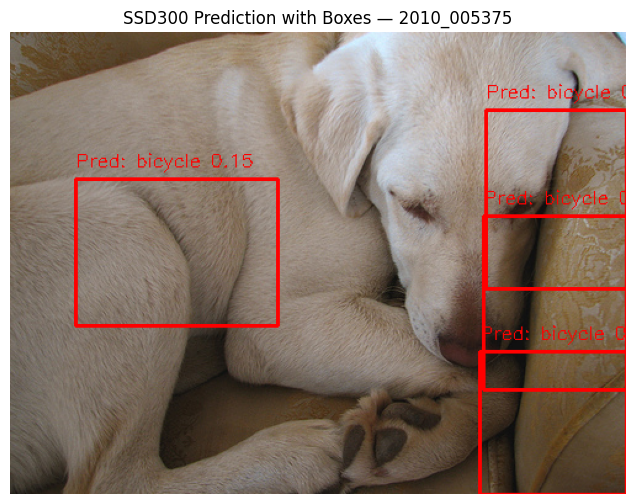


[2008_007693] Detections: 200 above score threshold.


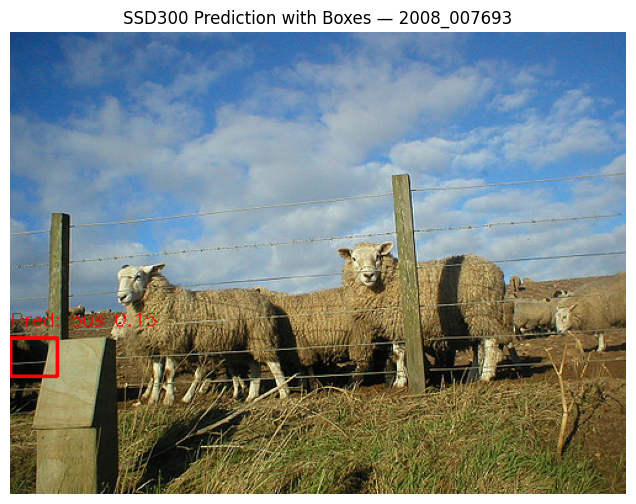


[2008_001430] Detections: 200 above score threshold.


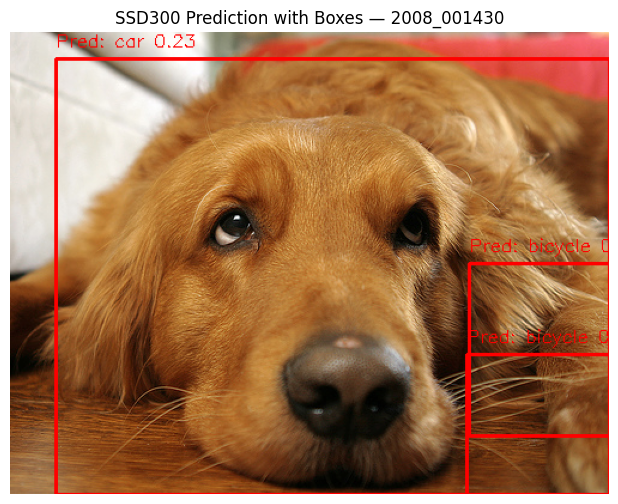

In [10]:
import os
import cv2
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torchvision.models.detection import ssd300_vgg16
from torchvision.models.detection.ssd import SSDClassificationHead
from torchvision.ops import nms

# Constants
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_DIR = "/kaggle/working/data/VOC2012/JPEGImages"
WEIGHTS_PATH = "outputs/ssd300_voc.pth"
NUM_CLASSES = 21
NUM_ANCHORS = [4, 6, 6, 6, 4, 4]
target_ids = ["2010_005375", "2008_007693", "2008_001430"]

# VOC labels
labels = [
    '__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]

# Load model
model = ssd300_vgg16(weights=None)
model.head.classification_head = SSDClassificationHead(
    in_channels=[512, 1024, 512, 256, 256, 256],
    num_anchors=NUM_ANCHORS,
    num_classes=NUM_CLASSES
)
model.load_state_dict(torch.load(WEIGHTS_PATH, map_location=DEVICE))
model = model.to(DEVICE).eval()

# Transform
transform = T.Compose([
    T.ToPILImage(),
    T.Resize((300, 300)),
    T.ToTensor()
])

# Draw boxes
def draw_boxes(img, boxes, labels_idx, scores=None, color=(0, 255, 0), label_prefix=""):
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = map(int, box)
        label = labels[labels_idx[i]]
        score_text = f"{label_prefix}{label}" + (f" {scores[i]:.2f}" if scores is not None else "")
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
        cv2.putText(img, score_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

# Predict
for img_id in target_ids:
    path = os.path.join(IMG_DIR, f"{img_id}.jpg")
    orig = cv2.imread(path)
    orig_rgb = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
    img_tensor = transform(orig_rgb).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        outputs = model(img_tensor)[0]

    boxes = outputs['boxes'].cpu()
    labels_idx = outputs['labels'].cpu()
    scores = outputs['scores'].cpu()

    print(f"\n[{img_id}] Detections: {len(scores)} above score threshold.")

    # Apply NMS and threshold
    keep = nms(boxes, scores, iou_threshold=0.45)
    boxes = boxes[keep]
    labels_idx = labels_idx[keep]
    scores = scores[keep]

    # Filter weak detections
    valid = scores > 0.15
    boxes, labels_idx, scores = boxes[valid], labels_idx[valid], scores[valid]

    # Rescale
    h_ratio = orig.shape[0] / 300
    w_ratio = orig.shape[1] / 300
    scaled_boxes = boxes.clone()
    scaled_boxes[:, [0, 2]] *= w_ratio
    scaled_boxes[:, [1, 3]] *= h_ratio

    # Draw predictions
    pred_img = orig_rgb.copy()
    draw_boxes(pred_img, scaled_boxes, labels_idx, scores, color=(255, 0, 0), label_prefix="Pred: ")

    plt.figure(figsize=(10, 6))
    plt.imshow(pred_img)
    plt.title(f"SSD300 Prediction with Boxes — {img_id}")
    plt.axis('off')
    plt.show()